In [117]:
from __future__ import division
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np,  matplotlib.pyplot as plt, sys, multiprocessing as mp, gc, pickle
from time import time
from pylab import plot, show, legend
sys.path.append('/home/postdoc/dsen/Desktop/codes/alphaSMC')
from PF import *
sys.path.append('/home/postdoc/dsen/Desktop/codes/alphaSMC/Lorenz63_model')
from Lorenz63 import *
from tqdm import trange
plt.rcParams['figure.figsize'] = (15.0, 3.0)
gc.enable()

In [30]:
dt = 1e-3
delta = 10*dt
T = 1000

sigma, rho, beta, noise_intensity, obs_noise = 10.0, 28.0, 8/3, 1e-1, 5e-1
theta = [sigma, rho, beta, noise_intensity, dt, delta, obs_noise]
x_0 = npr.randn(3)

y, latent = simulate_data_Lorenz63(theta, x_0, T)
data_Lorenz63 = dict(x_0=x_0, y=y)

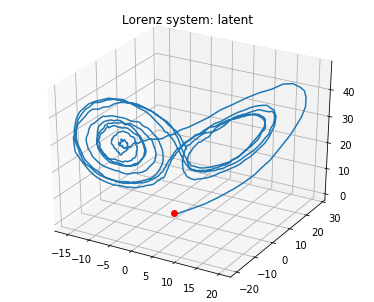

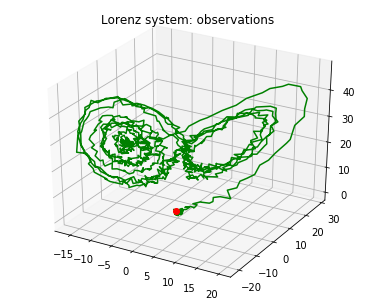

In [31]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(latent[:,0], latent[:,1], latent[:,2])
ax.plot(latent[0:1,0], latent[0:1,1], latent[0:1,2], 'ro')
plt.title("Lorenz system: latent")

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(y[:,0], y[:,1], y[:,2], color='green')
ax.plot(y[0:1,0], y[0:1,1], y[0:1,2], 'ro')
plt.title("Lorenz system: observations");

In [32]:
def test_fn(x) : return np.mean(x,1,keepdims=True)
data, potential, propagate = data_Lorenz63, potential_Lorenz63, propagate_Lorenz63

In [52]:
start = time()
logNC_truth, testfn_truth, _ = bootstrap_PF(data, theta, potential, propagate, test_fn, N=10**6, 
                                            store_paths=False, showprogress=True)
print(round((time()-start)/60,2), "minutes") 

100%|██████████| 1000/1000 [25:07<00:00,  1.50s/it]

25.14 minutes


In [54]:
logNC_truth[-1]

-2504.6677885206914

In [35]:
rep = 100
N = 5000
C_list = [10, 20, 30, 40, 50, 60, 70, 80]
logNC = np.zeros((rep,4,len(C_list),T+1))
testfn = np.zeros((rep,4,len(C_list),T))
N_rep = (N*np.ones(rep)).astype(int)

In [ ]:
for (i,C) in enumerate(C_list) :
    alpha_le = local_exchange_graph(N, C)
    alpha_dreg = d_regular_graph(N, C)
    if __name__ == '__main__': 
        def g0(N) : return bootstrap_PF(data, theta, potential, propagate, test_fn, N, store_paths=False);
        def g1(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_le, permute_alpha=False)
        def g2(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_dreg, permute_alpha=False)
        def g3(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_dreg, permute_alpha=True)
        pool = mp.Pool(processes=10)     
        output0 = pool.map(g0, N_rep) 
        output1 = pool.map(g1, N_rep) 
        output2 = pool.map(g2, N_rep) 
        output3 = pool.map(g3, N_rep) 
        pool.close()
        for r in range(rep) :
            logNC[r,0,i], testfn[r,0,i] = output0[r][0], output0[r][1] 
            logNC[r,1,i], testfn[r,1,i] = output1[r][0], output1[r][1] 
            logNC[r,2,i], testfn[r,2,i] = output2[r][0], output2[r][1] 
            logNC[r,3,i], testfn[r,3,i] = output3[r][0], output3[r][1] 
        del output0, output1, output2, output3

/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: R

In [83]:
u, s, vt = scipy.sparse.linalg.svds(alpha_dreg, k=2)
print(s)

[0.22113274 1.        ]


In [85]:
u, s, vt = scipy.sparse.linalg.svds(alpha_le, k=2)
print(s)

[0.99957902 1.        ]


In [90]:
for C in C_list : 
    _, s1, _ = scipy.sparse.linalg.svds(d_regular_graph(N, C), k=2)
    _, s2, _ = scipy.sparse.linalg.svds(local_exchange_graph(N, C), k=2)
    print("C =", C, np.min(s1), np.min(s2))

C = 10 0.5991460354079445 0.9999934860736143
C = 20 0.4332168338942288 0.9999737470583641
C = 30 0.3572309855152145 0.9999408492190702
C = 40 0.3104422717637154 0.9998947933350069
C = 50 0.27812027639163717 0.9998355804970894
C = 60 0.2539548671991138 0.9997632121078783
C = 70 0.2354930141004184 0.9996776898815143
C = 80 0.21977234137354315 0.9995790158436986


In [91]:
M = 1000
for C in C_list : 
    _, s1, _ = scipy.sparse.linalg.svds(d_regular_graph(M, C), k=2)
    _, s2, _ = scipy.sparse.linalg.svds(local_exchange_graph(M, C), k=2)
    print("C =", C, np.min(s1), np.min(s2))

C = 10 0.600400503443168 0.9998371593759438
C = 20 0.42886752912878123 0.9993438000936911
C = 30 0.3528492179056143 0.9985218592139725
C = 40 0.3056369233000255 0.997371823382583
C = 50 0.27198026389932156 0.9958943734233345
C = 60 0.24822929871265842 0.9940903838581822
C = 70 0.2293461137967815 0.9919609222908895
C = 80 0.2121806960082611 0.989507248654688


In [169]:
logNC_error = np.zeros(np.shape(logNC))
testfn_error = np.zeros(np.shape(testfn))
for t in range(np.shape(logNC)[-1]) :
    logNC_error[:,:,:,t] = logNC[:,:,:,t] - logNC_truth[t]
for t in range(np.shape(testfn)[-1]) :
    testfn_error[:,:,:,t] = testfn[:,:,:,t] - testfn_truth[t]
logNC_mse = np.sum(logNC_error**2,0)
testfn_mse = np.sum(testfn_error**2,0)

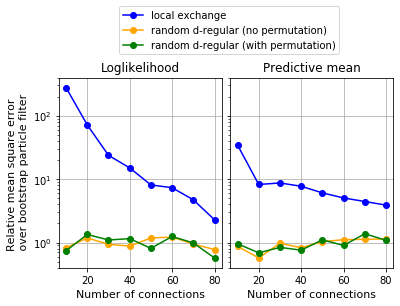

In [193]:
C_list = [10, 20, 30, 40, 50, 60, 70, 80]
colors = ["blue", "orange", "green"]
labels = ["local exchange", "random d-regular (no permutation)", "random d-regular (with permutation)"] 
ymin, ymax = 4e-1, 4e2
plt.rcParams['figure.figsize'] = (6.0, 3.5)
fig = plt.figure()
plt.subplots_adjust(wspace=5e-2)
plt.subplot(121)
for i in range(3) :
    plt.plot(C_list, logNC_mse[i+1,:,-1]/logNC_mse[0,:,-1], "o-", color=colors[i])
plt.grid(True)
plt.yscale('log')
plt.title("Loglikelihood", fontsize=12)
plt.ylabel("Relative mean square error \n over bootstrap particle filter", fontsize=11)
plt.xlabel("Number of connections", fontsize=11)
plt.ylim(ymin,ymax)
plt.subplot(122)
for i in range(3) :
    plt.plot(C_list, testfn_mse[i+1,:,-1]/testfn_mse[0,:,-1], "o-", label=labels[i], color=colors[i])
plt.grid(True)
plt.yscale('log')
plt.yticks(alpha=0)
plt.title("Predictive mean", fontsize=12)
plt.xlabel("Number of connections", fontsize=11)
plt.ylim(ymin,ymax)
plt.legend(bbox_to_anchor=(0.2, 0.9, 0.5, 0.5));
fig.savefig('MSE_vs_C.pdf', bbox_inches='tight', dpi=2000)

In [47]:
np.mean(logNC[:,:,:,-1],axis=0)

array([[-2505.35704592, -2505.24878969, -2505.31379184, -2505.35459664,
        -2505.48310131, -2505.24605784, -2505.04479639, -2505.34441738],
       [-2528.1245433 , -2514.51901506, -2510.7589112 , -2509.43423153,
        -2507.84238755, -2507.32481965, -2506.88368763, -2506.1867129 ],
       [-2505.32050616, -2505.11841708, -2505.30698541, -2505.31215346,
        -2505.48406036, -2505.18778638, -2505.37810857, -2505.31962482],
       [-2505.26241652, -2505.2631513 , -2505.36180483, -2505.30908584,
        -2505.10727134, -2505.2806052 , -2505.38930172, -2505.32586316]])

In [49]:
for i in range(3) :
    print(np.var(logNC[:,i+1,:,-1],axis=0)/np.var(logNC[:,0,:,-1],axis=0))

[9.70024224 7.14980375 5.26869247 2.99716741 4.34245462 3.10657357
 2.10170778 1.58304213]
[0.80391715 1.35563793 0.92809861 0.88009536 1.27526911 1.3496404
 0.71905728 0.73828826]
[0.74099822 1.43045671 1.08248214 1.25624745 1.08795028 1.28472406
 0.75207265 0.47613167]


In [118]:
np.save("/xtmp/alphaSMC_data/Lorenz63/logNC_lorenz.npy", logNC)
np.save("/xtmp/alphaSMC_data/Lorenz63/testfn_lorenz.npy", testfn)
np.save("/xtmp/alphaSMC_data/Lorenz63/logNC_lorenz_mse.npy", logNC_mse)
np.save("/xtmp/alphaSMC_data/Lorenz63/testfn_lorenz_mse.npy", testfn_mse)
import pickle
f = open("/xtmp/alphaSMC_data/Lorenz63/data_lorenz.pkl","wb")
pickle.dump(data_Lorenz63,f)
f.close()

In [141]:
500*np.arange(1,5)

array([ 500, 1000, 1500, 2000])

In [142]:
rep = 100
N_list = [500, 1000, 1500, 2000]
C_list = [5, 20]
logNC_2 = np.zeros((rep,4,len(C_list),len(N_list),T+1))
testfn_2 = np.zeros((rep,4,len(C_list),len(N_list),T))
N_rep = (N*np.ones(rep)).astype(int)

In [ ]:
for (i,C) in enumerate(C_list) :
    for (j,N) in enumerate(N_list) :
        alpha_le = local_exchange_graph(N, C)
        alpha_dreg = d_regular_graph(N, C)
        N_rep = (N*np.ones(rep)).astype(int)
        if __name__ == '__main__': 
            def g0(N) : return bootstrap_PF(data, theta, potential, propagate, test_fn, N, store_paths=False);
            def g1(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_le, permute_alpha=False)
            def g2(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_dreg, permute_alpha=False)
            def g3(N) : return alphaSMC(data, theta, potential, propagate, test_fn, alpha_dreg, permute_alpha=True)
            pool = mp.Pool(processes=10)     
            output0 = pool.map(g0, N_rep) 
            output1 = pool.map(g1, N_rep) 
            output2 = pool.map(g2, N_rep) 
            output3 = pool.map(g3, N_rep) 
            pool.close()
            for r in range(rep) :
                logNC_2[r,0,i,j], testfn_2[r,0,i,j] = output0[r][0], output0[r][1] 
                logNC_2[r,1,i,j], testfn_2[r,1,i,j] = output1[r][0], output1[r][1] 
                logNC_2[r,2,i,j], testfn_2[r,2,i,j] = output2[r][0], output2[r][1] 
                logNC_2[r,3,i,j], testfn_2[r,3,i,j] = output3[r][0], output3[r][1] 
            del output0, output1, output2, output3

/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: R

/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/postdoc/dsen/Desktop/codes/alphaSMC/PF.py:140: RuntimeWarning: invalid value encountered in less
  k = (s < r).sum(axis=0)
/auto/pkg/python-3.6/lib/python3.6/site-packages/scipy/sparse/base.py:555: R

In [146]:
np.save("/xtmp/alphaSMC_data/Lorenz63/logNC_2_lorenz.npy", logNC_2)
np.save("/xtmp/alphaSMC_data/Lorenz63/testfn_2_lorenz.npy", testfn_2)

In [148]:
np.shape(logNC_2)

(100, 4, 2, 4, 1001)

In [149]:
logNC_2_error = np.zeros(np.shape(logNC_2))
testfn_2_error = np.zeros(np.shape(testfn_2))
for t in range(np.shape(logNC_2)[-1]) :
    logNC_2_error[:,:,:,:,t] = logNC_2[:,:,:,:,t] - logNC_truth[t]
for t in range(np.shape(testfn_2)[-1]) :
    testfn_2_error[:,:,:,:,t] = testfn_2[:,:,:,:,t] - testfn_truth[t]
logNC_2_mse = np.sum(logNC_2_error**2,0)
testfn_2_mse = np.sum(testfn_2_error**2,0)

In [150]:
np.shape(logNC_2_mse)

(4, 2, 4, 1001)

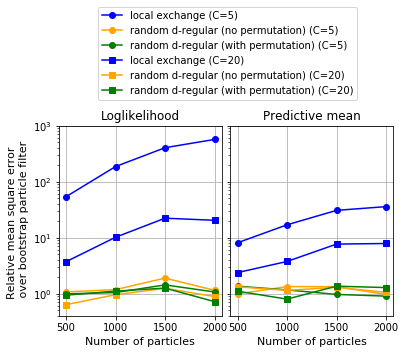

In [194]:
N_list = [500, 1000, 1500, 2000]
C_list = [5, 20]
labels = ["local exchange", "random d-regular (no permutation)", "random d-regular (with permutation)"] 
ymin, ymax = 4e-1, 1e3
fig = plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 3.5)
plt.subplots_adjust(wspace=5e-2)
plt.subplot(121)
plt.plot(N_list, logNC_2_mse[1,0,:,-1]/logNC_2_mse[0,0,:,-1], "o-", color="blue")
plt.plot(N_list, logNC_2_mse[2,0,:,-1]/logNC_2_mse[0,0,:,-1], "o-", color="orange")
plt.plot(N_list, logNC_2_mse[3,0,:,-1]/logNC_2_mse[0,0,:,-1], "o-", color="green")
plt.plot(N_list, logNC_2_mse[1,1,:,-1]/logNC_2_mse[0,1,:,-1], "s-", color="blue")
plt.plot(N_list, logNC_2_mse[2,1,:,-1]/logNC_2_mse[0,1,:,-1], "s-", color="orange")
plt.plot(N_list, logNC_2_mse[3,1,:,-1]/logNC_2_mse[0,1,:,-1], "s-", color="green")
plt.grid(True)
plt.yscale('log')
plt.title("Loglikelihood", fontsize=12)
plt.ylabel("Relative mean square error \n over bootstrap particle filter", fontsize=11)
plt.xlabel("Number of particles", fontsize=11)
plt.ylim(ymin,ymax)
plt.subplot(122)
plt.plot(N_list, testfn_2_mse[1,0,:,-1]/testfn_2_mse[0,0,:,-1], "o-", color="blue", label=labels[0]+" (C=5)")
plt.plot(N_list, testfn_2_mse[2,0,:,-1]/testfn_2_mse[0,0,:,-1], "o-", color="orange", label=labels[1]+" (C=5)")
plt.plot(N_list, testfn_2_mse[3,0,:,-1]/testfn_2_mse[0,0,:,-1], "o-", color="green", label=labels[2]+" (C=5)")
plt.plot(N_list, testfn_2_mse[1,1,:,-1]/testfn_2_mse[0,1,:,-1], "s-", color="blue", label=labels[0]+" (C=20)")
plt.plot(N_list, testfn_2_mse[2,1,:,-1]/testfn_2_mse[0,1,:,-1], "s-", color="orange", label=labels[1]+" (C=20)")
plt.plot(N_list, testfn_2_mse[3,1,:,-1]/testfn_2_mse[0,1,:,-1], "s-", color="green", label=labels[2]+" (C=20)")
plt.grid(True)
plt.yscale('log')
plt.yticks(alpha=0)
plt.title("Predictive mean", fontsize=12)
plt.xlabel("Number of particles", fontsize=11)
plt.ylim(ymin,ymax)
plt.legend(bbox_to_anchor=(0.31, 1.15, 0.5, 0.5))
fig.savefig('MSE_vs_N.pdf', bbox_inches='tight', dpi=2000)

In [153]:
np.save("/xtmp/alphaSMC_data/Lorenz63/logNC_2_lorenz_mse.npy", logNC_2_mse)
np.save("/xtmp/alphaSMC_data/Lorenz63/testfn_2_lorenz_mse.npy", testfn_2_mse)